In [139]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from src import load_data, datasets, conv_lstm, evaluate, utils
import netCDF4 as nc
from torch import nn
from datetime import datetime, timedelta
import gdal
import os
from PIL import Image
import PIL
import torchvision
from torchvision.transforms import ToPILImage, ToTensor, Lambda, RandomRotation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
landcover_nc = nc.Dataset('../data/NA_NALCMS_LC_30m_LAEA_mmu12_urb05_n40-45w75-90_erie.nc', 'r')

In [177]:
a=torch.Tensor([[1,2,3],[1,2,3]])
b=torch.Tensor([1,2,3])
a-b

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [163]:
t=torchvision.transforms.Compose([
    Lambda(lambda steps: [ToPILImage(mode='F')(step) for step in steps]),
    Lambda(lambda steps: [RandomRotation(90,resample=Image.NEAREST)(step) for step in steps]),
    Lambda(lambda steps: torch.cat([ToTensor()(step) for step in steps]))
    ])

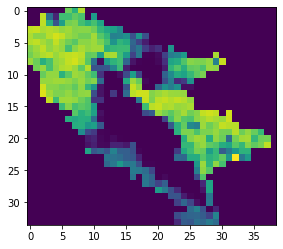

In [176]:
r=t(a)
plt.imshow(r[14])

In [23]:
lats,lons=load_data.load_dem_lats_lons()

In [190]:
a=torch.ones((34,39))
b=torch.zeros((34+2,39+2))
b[...,1:-1,1:-1]=a
b

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [48]:
seq_len = 5*24
seq_steps = 2
stateful_lstm = False
validation_fraction, val_start, val_end = None, None, None

if stateful_lstm:
    val_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(hours=seq_len * seq_steps)  # first day for which to make a prediction in train set
    val_end = '2010-09-30'
    train_start = '2010-10-01'
    train_end = '2012-12-31'
else:
    validation_fraction = 0.1
    train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(hours=seq_len * seq_steps)  # first day for which to make a prediction in train set
    train_end = '2012-12-31'
test_start = '2013-01-01'
test_end = '2014-12-31'

In [49]:
rdrs_vars = list(range(8))
train_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, train_start, train_end, include_simulated_streamflow=True,out_lats=lats,out_lons=lons)

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
ds=datasets.GeophysicalGridDataset(True,True,True,True,lamin,lamax,lomin,lomax)

../src/load_data.py:467: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  soil[i*8 + ((j-1)*4 + layer-1)] = soil_nc['Band{}'.format(layer)][:][::-1,:]\


In [66]:
lr=train_dataset.__getitem__(0)['x_conv'][45,4]

In [168]:
um=utils.map_to_geophysical_coords(train_dataset.in_lats, train_dataset.in_lons, ds.lats,ds.lons)

In [176]:
lrbig=utils.upsample_to_geophysical_input(lr,*um)
plt.imshow(lrbig)

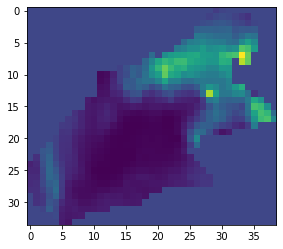

In [159]:
plt.imshow(lr)

In [15]:
s=gdal.Open('NETCDF:/home/mgauch/RDRS_CaPA24hr_forcings_final.nc:RDRS_HU_40m')

In [100]:
ds.GetDriver()

<osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x7fda3dda7690> >

In [16]:
sr=s.GetSpatialRef()

In [17]:
proj4 = sr.ExportToProj4()
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromProj4(proj4)

0

In [18]:
proj4

'+proj=ob_tran +o_proj=longlat +lon_0=339.131100000000004 +o_lon_p=0 +o_lat_p=6.66816850000000017 +a=6371220 +b=6371220 +to_meter=0.0174532925199 +wktext'

In [81]:
from osgeo import osr,ogr

In [75]:
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(4326)

6

In [79]:
coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

In [82]:
driver = ogr.GetDriverByName('netCDF')

In [84]:
outputShapefile = r'/home/mgauch/test.nc'
outDataSet = driver.CreateDataSource(outputShapefile)

In [85]:
outLayer = outDataSet.CreateLayer("basemap_4326")

In [83]:
inLayerDefn = inLayer.GetLayerDefn()
for i in range(0, s.GetFieldCount()):
    fieldDefn = inLayerDefn.GetFieldDefn(i)
    outLayer.CreateField(fieldDefn)

<osgeo.ogr.Driver; proxy of <Swig Object of type 'OGRDriverShadow *' at 0x7fda3dda7c90> >

In [93]:
s.

0

In [2]:
import os, sys, glob, argparse
from osgeo import gdal, osr

o_srs = osr.SpatialReference()
o_srs.ImportFromEPSG(4326)

outputfilename = '/home/mgauch/tmptest/testout.tif'
tempfile = '/home/mgauch/tmptest/tmp.tif'

# Specify the layer name to read
layer_name = "RDRS_HU_40m"

# Open netcdf file.nc with gdal
dsR = gdal.Open("NETCDF:/home/mgauch/RDRS_CaPA24hr_forcings_final.nc:{}".format(layer_name))
red_srs = osr.SpatialReference()
red_srs.ImportFromWkt(dsR.GetProjectionRef())
red_transform = osr.CoordinateTransformation(red_srs, o_srs)

# Read full data from netcdf

print('Reading red band into memory.')
red = dsR.ReadAsArray(0, 0, dsR.RasterXSize, dsR.RasterYSize)

Reading red band into memory.


In [3]:
# Stack data and output
print('Stacking data.')
driver = gdal.GetDriverByName('GTiff')
stack = driver.Create('/vsimem/stack.tif', dsR.RasterXSize, dsR.RasterYSize, 3, gdal.GDT_CFloat32)
stack.SetProjection(red_srs.ExportToWkt())

Stacking data.


0

In [10]:
GeoT = dsR.GetGeoTransform()
stack.SetGeoTransform(GeoT)
for i in range(1,3+1):
    stack.GetRasterBand(i).WriteArray(red[i])
print('Warping data to new projection.')
warped = gdal.Warp('/home/mgauch/tmptest/warped.tif', stack, dstSRS = o_srs, outputType = gdal.GDT_CFloat32)

print('Writing output to disk.')

outRaster = gdal.Translate(outputfilename, '/home/mgauch/tmptest/warped.tif')

Warping data to new projection.


TypeError: in method 'wrapper_GDALWarpDestName', argument 4 of type 'GDALWarpAppOptions *'

In [73]:
outRaster = None
red = None
tmp_ds = None
dsR = None

print('Processing complete.')

Processing complete.


In [11]:
stack

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f5b16c31630> >